In [4]:
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [5]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ray 2.1.0 requires click<=8.0.4,>=7.0, but you have click 8.1.3 which is incompatible.


## Fitting a function with gradient descent

In [6]:
from ipywidgets import interact
from fastai.basics import *

plt.rc('figure', dpi=90)
def plot_function(f, title=None, min=-2.1, max=2.1, color='r', ylim=None):
    x = torch.linspace(min, max, 100)[:, None]
    if ylim: plt.ylim(ylim)
    plt.plot(x, f(x), color)
    if title is not None: plt.title(title)

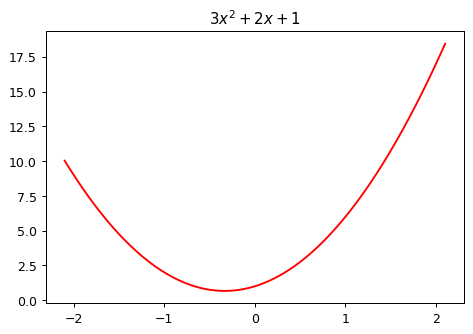

In [7]:
def f(x): return 3*x**2 + 2*x + 1
plot_function(f, '$3x^2 + 2x + 1$')

In [8]:
def quad(a, b, c, x): return a*x**2 + b*x + c

If we fix some particular values of a, b, and c, then we'll have made a quadratic. To fix values passed to a function in python, we use the `partial` function, like so:

In [11]:
def mk_quad(a, b, c): return partial(quad, a, b, c)

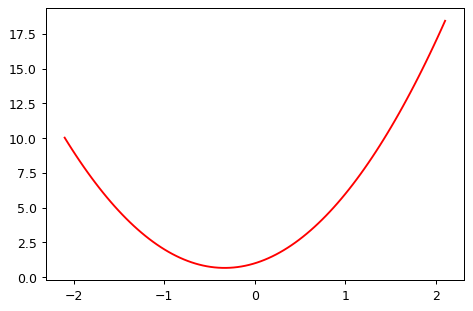

In [12]:
f2 = mk_quad(3, 2, 1)
plot_function(f2)

In [31]:
# Creates noise using a normal distribution with 'std_dev' and 'num_samples. Returns a [num_samples, 1] numpy array'
def noise(std_dev, num_samples): return np.random.normal(scale=std_dev, size=num_samples)

# Add noise to the data
def add_noise(x, std_dev1, std_dev2): return x * (1 + noise(std_dev1, x.shape)) + noise(std_dev2, x.shape)

In [34]:
np.random.seed(42)

x = torch.linspace(-2, 2, steps=20)[:, None] # [:, None] converts object to a [20, 1] tensor
y = add_noise(f(x), std_dev1=0.15, std_dev2=0.15)
print(x[:5])
print(y[:5])
print(x.shape)
print(y.shape)

tensor([[-2.0000],
        [-1.7895],
        [-1.5789],
        [-1.3684],
        [-1.1579]])
tensor([[9.8904],
        [6.8481],
        [5.8484],
        [4.5538],
        [2.5297]], dtype=torch.float64)
torch.Size([20, 1])
torch.Size([20, 1])


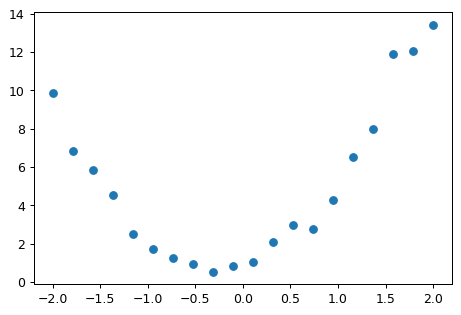

In [35]:
plt.scatter(x, y)

In [39]:
@interact(a=1.1, b=1.1, c=1.1)
def plot_quad(a, b, c):
    quad = mk_quad(a, b, c)
    plt.scatter(x, y)
    loss = mae(quad(x), y)
    plot_function(quad, ylim=(-3, 12), title=f'MAE {loss: .2f}')

interactive(children=(FloatSlider(value=1.1, description='a', max=3.3000000000000003, min=-1.1), FloatSlider(v…

## Automating gradient descent
For automatic gradient descent, first we need a function that takes all the parameters `a`, `b`, and `c` as a single vector input, and returns the value mae() based on those parameters:

In [61]:
# Define a quadratic function
def f3(a, b, c, x): return a*x**2 + b*x + c
def mk_quad3(a, b, c): return partial(f3, a, b, c)
quad3 = mk_quad3(3, 2, 1)

tensor([[-2.0000],
        [-1.7895],
        [-1.5789],
        [-1.3684],
        [-1.1579]]) tensor([[9.8904],
        [6.8481],
        [5.8484],
        [4.5538],
        [2.5297]], dtype=torch.float64)
torch.Size([20, 1])
torch.Size([20, 1])


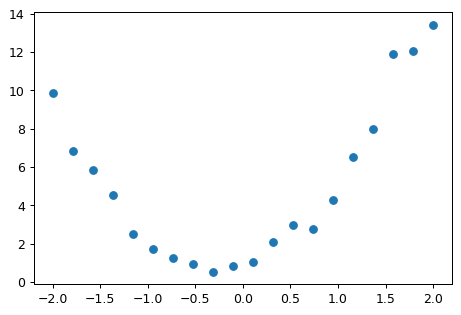

In [62]:
# Define a noise using a random distribution
def noise3(std_dev, num_samples): return np.random.normal(scale=std_dev, size=num_samples)
# Define function to add noise to the data
def add_noise3(x, std_dev1, std_dev2): return x * (1 + noise3(std_dev1, x.shape)) + noise3(std_dev2, x.shape)

# Create data using quadratic function
np.random.seed(42)
x = torch.linspace(-2, 2, steps=20)[:, None]
y = add_noise3(quad3(x), 0.15, 0.15)

print(x[:5], y[:5])
print(x.shape)
print(y.shape)
plt.scatter(x, y)

Now we need a function that takes all the parameters a, b, and c as a single vector input, and returns the value mae() based on those parameters:
Next, we will create a weight vector which consists of some arbritrary starting point for our parameters. We'll put them all into a single tensor:

In [67]:
# Define a funtion to get the mae using the quadratic function
def quad_mae(params):
    f = mk_quad3(*params)
    return mae(f(x), y)

quad_mae([1.1, 1.1, 1.1])

# Define weight vector
weights = torch.tensor([1.1, 1.1, 1.1])
weights.requires_grad_()

# Define loss
loss = quad_mae(weights)
loss.backward()

print(weights.grad)

tensor([-1.4615, -0.0316, -0.7000])


According to these gradients, all our parameters are a little low. So let's increase them a bit. If we subtract the gradient, multiplied by a small number, that should improve them a bit:

In [69]:
learning_rate = 0.1
with torch.no_grad():
    weights -= weights.grad * learning_rate
    loss = quad_mae(weights)
    
print(f'loss: {loss: .2f}')

loss:  1.83


In [71]:
for i in range(10):
    loss = quad_mae(weights)
    loss.backward()
    with torch.no_grad(): weights -= weights.grad * learning_rate
    print(f'step={i}, loss={loss:.2f}')

step=0, loss=1.83
step=1, loss=1.41
step=2, loss=0.92
step=3, loss=0.70
step=4, loss=1.27
step=5, loss=1.66
step=6, loss=1.80
step=7, loss=1.62
step=8, loss=1.16
step=9, loss=0.61


## How a neural network approximates any given function
The way a neural network approximates a function actually turns out to be very simple. The key trick is to combine two extremely basic steps:
1. Matrix multiplication, which is just multiplying things together and then adding them up
2. The function `max(x,0)`, which simply replaces all negative numbers with zero.

In PyTorch, the function `max(x,0)` is written as `torch.clip(x,0)`. The combination of a linear function and this `max()` is called a **rectified linear unit**.

In [72]:
def relu(m, c, x):
    y = m*x + c
    return torch.clip(y, 0)

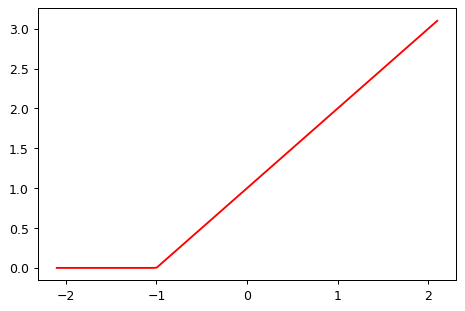

In [73]:
plot_function(partial(relu, 1, 1))

Instead of `torch.clip(y, 0)`, we can instead use `F.relu(x)`, which does exactly the same thing. In Pytorch, `F` refers to the `torch.nn.functional`.

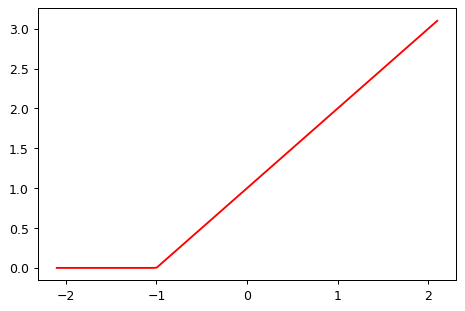

In [77]:
import torch.nn.functional as F
def relu2(m, c, x): return F.relu(m*x + c)
plot_function(partial(relu2, 1, 1))

In [78]:
@interact(m=1.1, c=1.1)
def plot_relu(m, c):
    plot_function(partial(relu2, m, c))

interactive(children=(FloatSlider(value=1.1, description='m', max=3.3000000000000003, min=-1.1), FloatSlider(v…

In [80]:
def double_relu(m1, c1, m2, c2, x):
    return relu(m1, c1, x) + relu(m2, c2, x)

@interact(m1=-1.5, c1=-1.5, m2=1.5, c2=1.5)
def plot_double_relu(m1, c1, m2, c2):
    plot_function(partial(double_relu, m1, c1, m2, c2))

interactive(children=(FloatSlider(value=-1.5, description='m1', max=1.5, min=-4.5), FloatSlider(value=-1.5, de…

In [83]:
def triple_relu(m1, c1, m2, c2, m3, c3, x):
    return relu(m1, c1, x) + relu(m2, c2, x) + relu(m3, c3, x)

@interact(m1=-1.5, c1=-1.5, m2=1.5, c2=1.5, m3=1.5, c3=1.5)
def plot_triple_relu(m1, c1, m2, c2, m3, c3):
    plot_function(partial(triple_relu, m1, c1, m2, c2, m3, c3))

interactive(children=(FloatSlider(value=-1.5, description='m1', max=1.5, min=-4.5), FloatSlider(value=-1.5, de…